In [64]:
%pylab inline

import copy
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from PIL import Image

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [84]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
train_data = X_train.reshape(-1, 28, 28, 1)
test_data = X_test.reshape(-1, 28, 28, 1)

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# perform 80 / 20 train - test split
# training images will both act as the input as well as 
# the ground truth similar to the labels you have in the classification task.
train_X, valid_X, train_Y, valid_Y = train_test_split(train_data, train_data, test_size = 0.2, random_state = 13)

In [27]:
np.max(train_data)

1.0

(10000, 28, 28)

In [53]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [54]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [55]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [56]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
# visualize layers created using summary function
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_46 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_47 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [57]:
autoencoder_train = autoencoder.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_Y))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 576s 12ms/step - loss: 0.0200 - val_loss: 0.0182
Epoch 2/10
48000/48000 [==============================] - 573s 12ms/step - loss: 0.0094 - val_loss: 0.0135
Epoch 3/10
48000/48000 [==============================] - 555s 12ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 4/10
48000/48000 [==============================] - 574s 12ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 5/10
48000/48000 [==============================] - 579s 12ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/10
48000/48000 [==============================] - 587s 12ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 7/10
48000/48000 [==============================] - 606s 13ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 8/10
48000/48000 [==============================] - 602s 13ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/10
48000/48000 [==============================] - 603s 13ms/step - loss: 0.0035 - val_

ValueError: x and y must have same first dimension, but have shapes (200,) and (10,)

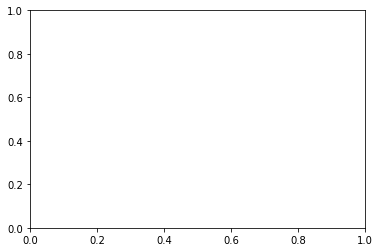

In [58]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [112]:
# Deep CNN to predict class of fashion_MNIST data
# filters for each convolutional layer: 32, kernel size 3 * 3, strides = 1, padding = valid (no padding)
# Pooling method: MaxPooling2D, network depth, structure: 2 convolution layers each with maxpooling and dropout layer, and one hidden dense layer



(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
train_data = X_train.reshape(-1, 28, 28, 1)
test_data = X_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(np.array(y_train))

y_test = to_categorical(np.array(y_test))

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (28, 28 , 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
model.fit(train_data, y_train, batch_size=batch_size,epochs=20,verbose=1,validation_split = 0.2)

scores = model.evaluate(test_data, y_test, verbose = 0)
print("Performance on test dataset " + "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 29s 596us/step - loss: 0.4620 - acc: 0.8338 - val_loss: 0.3866 - val_acc: 0.8562
Epoch 2/20
48000/48000 [==============================] - 27s 571us/step - loss: 0.3192 - acc: 0.8832 - val_loss: 0.2976 - val_acc: 0.8908
Epoch 3/20
48000/48000 [==============================] - 27s 571us/step - loss: 0.2772 - acc: 0.8980 - val_loss: 0.2716 - val_acc: 0.9005
Epoch 4/20
48000/48000 [==============================] - 27s 570us/step - loss: 0.2456 - acc: 0.9084 - val_loss: 0.2802 - val_acc: 0.8968
Epoch 5/20
48000/48000 [==============================] - 27s 571us/step - loss: 0.2262 - acc: 0.9144 - val_loss: 0.2661 - val_acc: 0.9080
Epoch 6/20
48000/48000 [==============================] - 27s 571us/step - loss: 0.2022 - acc: 0.9232 - val_loss: 0.2619 - val_acc: 0.9074
Epoch 7/20
48000/48000 [==============================] - 27s 571us/step - loss: 0.1858 - acc: 0.9293 - val_loss: 0.

In [97]:
scores

0.2890710671901703

In [117]:
# perform transform learning on fashion-mnist dataset
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from scipy.misc import imresize
from sklearn.metrics import log_loss

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

y_train = to_categorical(np.array(y_train))
X_train = np.dstack([X_train]*3)


y_test = to_categorical(np.array(y_test))
X_test = np.dstack([X_test]*3)

# Reshape images as per the tensor format required by tensorflow
X_train = X_train.reshape(-1, 28,28,3)
X_test= X_test.reshape (-1,28,28,3)


In [118]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_test])

# Normalise the data and change data type
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.astype('float32')
X_test /= 255



In [119]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 10)

In [141]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [120]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 150, 150, 3), (12000, 150, 150, 3), (48000, 10), (12000, 10))

In [122]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [123]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val), batch_size=256, verbose=1)

12000/12000 [==============================] - 1755s 146ms/step


In [124]:
train_features.shape[0]

48000

In [138]:
# Flatten extracted features
train_features = np.reshape(train_features, (train_features.shape[0], 4*4*512))
test_features = np.reshape(test_features, (test_features.shape[0], 4*4*512))
val_features = np.reshape(val_features, (val_features.shape[0], 4*4*512))

In [139]:
# Add Dense and Dropout layers on top of VGG19 pre-trained
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [140]:
history = model.fit(train_features, y_train,
          batch_size=256,
          epochs=20,
          verbose=1,
          validation_data=(val_features, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 133us/step - loss: 2.3851 - acc: 0.1010 - val_loss: 2.3717 - val_acc: 0.0956
Epoch 2/20
48000/48000 [==============================] - 4s 90us/step - loss: 2.3026 - acc: 0.0991 - val_loss: 2.3715 - val_acc: 0.0942
Epoch 3/20
48000/48000 [==============================] - 4s 90us/step - loss: 2.3026 - acc: 0.0985 - val_loss: 2.3717 - val_acc: 0.0937
Epoch 4/20
48000/48000 [==============================] - 4s 91us/step - loss: 2.3026 - acc: 0.0979 - val_loss: 2.3720 - val_acc: 0.0926
Epoch 5/20
48000/48000 [==============================] - 4s 91us/step - loss: 2.3027 - acc: 0.0983 - val_loss: 2.3717 - val_acc: 0.0942
Epoch 6/20
48000/48000 [==============================] - 4s 89us/step - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3716 - val_acc: 0.0937
Epoch 7/20
48000/48000 [==============================] - 4s 80us/step - loss: 2.3026 - acc: 0.0992 - val_loss: 2.3722 - val_ac

In [134]:
score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.3617039760589598
Test accuracy: 0.064


In [ ]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [35]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection

#import gensim
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from pathlib import Path
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
# loading data from two datasets each contain all different category of URLs (benigh or malicious)
benign_url_df = pd.read_csv('benign-urls.txt')

# rename the column name 
benign_url_df.columns = ['url']
# make label of each url
benign_url_df['isMalicious'] = 0
malicious_url_df = pd.read_csv('malicious-urls.txt')

# rename the column name 
malicious_url_df.columns = ['url']
# make label of each url
malicious_url_df['isMalicious'] = 1
benign_url_df.sample(n=25).head(25)
malicious_url_df.sample(n=25).head(25)

,url,isMalicious
77,.asmallworld.net,1
1020,.spys.one,1
309,.ello.co,1
15,.abparquitectura.es,1
626,.meneame.net,1
673,.myactivedirectory.com,1
1147,.ultrasurf.us,1
210,.couchsurfing.org,1
1170,.us-proxy.org,1
450,.hipstamatic.com,1


In [10]:
df = pd.concat([benign_url_df, malicious_url_df], ignore_index=True)
df.sample(n=20000).head(25)

,url,isMalicious
14863,.r7---sn-4g57kn6e.googlevideo.com,0
14308,.r6---sn-hp57kn76.googlevideo.com,0
27700,.eimplesk.westeurope.cloudapp.azure.com,0
21498,.answers-dev.microsoft.com,0
966,.jigsaw.google.com,0
8270,.r1---sn-5uaeznd7.googlevideo.com,0
26455,.dcservicesgatewayuat.microsoft.com,0
41788,.vstfbingext.partners.extranet.microsoft.com,0
40226,.terrell.uksouth.cloudapp.azure.com,0
67128,.telex.cc,1


In [11]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.url]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
 
# Step 3: Extract labels form df to numpy array
target = np.array(df.isMalicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (67351, 75) Vector dimension of target:  (67351,)


In [12]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, test_size=0.25, random_state=33)

In [13]:
# GENERAL get layer dimensions for any model!
def print_layers_dims(model):
    l_layers = model.layers
    # Note None is ALWAYS batch_size
    for i in range(len(l_layers)):
        print(l_layers[i])
        print('Input Shape: ', l_layers[i].input_shape, 'Output Shape: ', l_layers[i].output_shape)

# GENERAL save model to disk function!
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    #have h5py installed
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    

# GENERAL load model from disk function!
def load_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    with open(fileModelJSON, 'r') as f:
         model_json = json.load(f)
         model = model_from_json(model_json)
    
    model.load_weights(fileWeights)
    return model

In [40]:
## Deep Learning model Definition --- B --- (1D Convolution and LSTM)

def lstm_conv(max_len=75, emb_dim=32, max_vocab_len=100, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    # Conv layer
    conv = Convolution1D(kernel_size=5, filters=256, \
                     border_mode='same')(emb)
    conv = ELU()(conv)

    conv = MaxPooling1D(pool_size=4)(conv)
    conv = Dropout(0.5)(conv)

    # LSTM layer
    lstm = LSTM(lstm_output_size)(conv)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [41]:
# Fit model and Cross-Validation, ARCHITECTURE 2 CONV + LSTM
epochs = 5
batch_size = 32

model = lstm_conv()
model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
print_layers_dims(model)

Epoch 1/5
50513/50513 [==============================] - 49s 960us/step - loss: 0.1143 - acc: 0.9796
Epoch 2/5
50513/50513 [==============================] - 45s 881us/step - loss: 0.0637 - acc: 0.9807
Epoch 3/5
50513/50513 [==============================] - 45s 892us/step - loss: 0.0423 - acc: 0.9817
Epoch 4/5
50513/50513 [==============================] - 47s 932us/step - loss: 0.0325 - acc: 0.9854
Epoch 5/5
16838/16838 [==============================] - 4s 222us/step

Final Cross-Validation Accuracy 0.9890129469058083 

Input Shape:  (None, 75) Output Shape:  (None, 75)
Input Shape:  (None, 75) Output Shape:  (None, 75, 32)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 32)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 256) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 256) Output Shape:  (None, 18, 256)
Input Shape:  (None, 18, 256) Output Shape:  (None, 18, 256)
Input Shape:  (None, 18, 256) Output Shape:  (None, 32)
Input S

In [43]:
model_name = "deeplearning_1DConvLSTM"
save_model(model_name + ".json", model_name + ".h5")
model = load_model(model_name + ".json", model_name + ".h5")
#print_layers_dims(model)

OSError: Unable to open file (file signature not found)

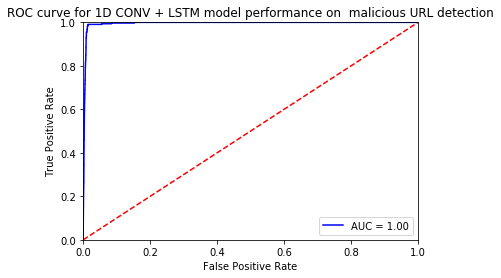

In [44]:
target_pred = model.predict(X_test)
# drawing roc curve to examine predicting power of fully connected CNN model
fpr, tpr, threshold = roc_curve(target_test, target_pred)
roc_auc = auc(fpr, tpr)


plt.title('ROC curve for 1D CONV + LSTM model performance on  malicious URL detection')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
## Deep Learning model Definition --- C --- (1D Convolutions and Fully Connected Layers)

def conv_fully(max_len=75, emb_dim=32, max_vocab_len=100, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    
    def sum_1d(X):
        return K.sum(X, axis=1)
    
    def get_conv_layer(emb, kernel_size=5, filters=256):
        # Conv layer
        conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                     border_mode='same')(emb)
        conv = ELU()(conv)

        conv = Lambda(sum_1d, output_shape=(filters,))(conv)
        #conv = BatchNormalization(mode=0)(conv)
        conv = Dropout(0.5)(conv)
        return conv
        
    # Multiple Conv Layers
    
    # calling custom conv function from above
    conv1 = get_conv_layer(emb, kernel_size=2, filters=256)
    conv2 = get_conv_layer(emb, kernel_size=3, filters=256)
    conv3 = get_conv_layer(emb, kernel_size=4, filters=256)
    conv4 = get_conv_layer(emb, kernel_size=5, filters=256)

    # Fully Connected Layers
    merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

    hidden1 = Dense(1024)(merged)
    hidden1 = ELU()(hidden1)
    hidden1 = BatchNormalization(mode=0)(hidden1)
    hidden1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(1024)(hidden1)
    hidden2 = ELU()(hidden2)
    hidden2 = BatchNormalization(mode=0)(hidden2)
    hidden2 = Dropout(0.5)(hidden2)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(hidden2)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# Fit model and Cross-Validation, ARCHITECTURE 3 CONV + FULLY CONNECTED
epochs = 5
batch_size = 32

model = conv_fully()
model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
print_layers_dims(model)

Epoch 1/5
50513/50513 [==============================] - 91s 2ms/step - loss: 0.3466 - acc: 0.8575
Epoch 2/5
50513/50513 [==============================] - 90s 2ms/step - loss: 0.1198 - acc: 0.9725
Epoch 3/5
50513/50513 [==============================] - 90s 2ms/step - loss: 0.1046 - acc: 0.9744
Epoch 4/5
50513/50513 [==============================] - 89s 2ms/step - loss: 0.0918 - acc: 0.9755
Epoch 5/5
16838/16838 [==============================] - 6s 356us/step

Final Cross-Validation Accuracy 0.9810547570970424 

Input Shape:  (None, 75) Output Shape:  (None, 75)
Input Shape:  (None, 75) Output Shape:  (None, 75, 32)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 32)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 32) Output Shape:  (None, 75, 256)
Input Shape:  (None, 75, 256) Output Shape:  (None, 75, 256)
Input Shape: 

In [22]:
# get probabilities of target predictions
target_proba = model.predict(X_test, batch_size=1)

In [24]:
model_name = "deeplearning_1DConv"
save_model(model_name + ".json", model_name + ".h5")
model = load_model(model_name + ".json", model_name + ".h5")
#print_layers_dims(model)

In [25]:
# Making new prediction
test_url_mal = "naureen.net/etisalat.ae/index2.php"
test_url_benign = "sixt.com/php/reservation?language=en_US"

url = test_url_benign

In [26]:
# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)

In [27]:
target_proba = model.predict(X, batch_size=1)
def print_result(proba):
    if proba > 0.5:
        return "malicious"
    else:
        return "benign"
print("Test URL:", url, "is", print_result(target_proba[0]))

Test URL: sixt.com/php/reservation?language=en_US is benign


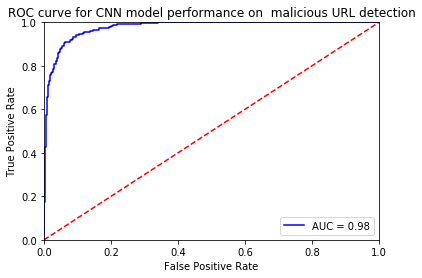

In [37]:
target_pred = model.predict(X_test)
# drawing roc curve to examine predicting power of fully connected CNN model
fpr, tpr, threshold = roc_curve(target_test, target_pred)
roc_auc = auc(fpr, tpr)


plt.title('ROC curve for CNN model performance on  malicious URL detection')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()